Amardeep Singh

E23CSEU2189

In [ ]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/edges2shoes.tar.gz
!tar -xvf edges2shoes.tar.gz

--2026-02-22 17:53:21--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/edges2shoes.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2165283376 (2.0G) [application/x-gzip]
Saving to: ‘edges2shoes.tar.gz’

edges2shoes.tar.gz    4%[                    ] 100.70M  6.08MB/s    eta 6m 36s 

In [ ]:
import os
from PIL import Image

os.makedirs("dataset/train/input", exist_ok=True)
os.makedirs("dataset/train/target", exist_ok=True)

source_folder = "edges2shoes/train"

for i, img_name in enumerate(os.listdir(source_folder)):
    if i > 1000:  # LIMIT for faster training (remove this line for full dataset)
        break

    img = Image.open(os.path.join(source_folder, img_name))
    w, h = img.size

    input_img = img.crop((0, 0, w//2, h))
    target_img = img.crop((w//2, 0, w, h))

    input_img.save(f"dataset/train/input/{img_name}")
    target_img.save(f"dataset/train/target/{img_name}")

print("Dataset Prepared Successfully!")

Dataset Prepared Successfully!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import matplotlib.pyplot as plt

# ===============================
# CONFIG
# ===============================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 4
LR = 0.0002
EPOCHS = 50
LAMBDA_L1 = 100
IMAGE_SIZE = 256

# ===============================
# DATASET
# ===============================
class PairedDataset(Dataset):
    def __init__(self, input_dir, target_dir, transform=None):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.transform = transform
        self.images = os.listdir(input_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        input_img = Image.open(os.path.join(self.input_dir, img_name)).convert("RGB")
        target_img = Image.open(os.path.join(self.target_dir, img_name)).convert("RGB")

        if self.transform:
            input_img = self.transform(input_img)
            target_img = self.transform(target_img)

        return input_img, target_img

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = PairedDataset(
    "dataset/train/input",
    "dataset/train/target",
    transform
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# ===============================
# U-NET GENERATOR
# ===============================
class Down(nn.Module):
    def __init__(self, in_c, out_c, normalize=True):
        super().__init__()
        layers = [nn.Conv2d(in_c, out_c, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_c))
        layers.append(nn.LeakyReLU(0.2))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class Up(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(True)
        )

    def forward(self, x, skip):
        x = self.model(x)
        return torch.cat([x, skip], 1)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = Down(3, 64, False)
        self.d2 = Down(64, 128)
        self.d3 = Down(128, 256)
        self.d4 = Down(256, 512)

        self.u1 = Up(512, 256)
        self.u2 = Up(512, 128)
        self.u3 = Up(256, 64)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.d1(x)
        d2 = self.d2(d1)
        d3 = self.d3(d2)
        d4 = self.d4(d3)

        u1 = self.u1(d4, d3)
        u2 = self.u2(u1, d2)
        u3 = self.u3(u2, d1)

        return self.final(u3)

# ===============================
# PATCHGAN DISCRIMINATOR
# ===============================
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(6, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 1, 4, 1, 1)
        )

    def forward(self, input_img, target_img):
        x = torch.cat([input_img, target_img], dim=1)
        return self.model(x)

# ===============================
# BASELINE CNN
# ===============================
class BaselineCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

# ===============================
# INITIALIZE MODELS
# ===============================
generator = Generator().to(DEVICE)
discriminator = Discriminator().to(DEVICE)
baseline = BaselineCNN().to(DEVICE)

opt_G = optim.Adam(generator.parameters(), lr=LR, betas=(0.5, 0.999))
opt_D = optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))
opt_base = optim.Adam(baseline.parameters(), lr=LR)

criterion_GAN = nn.MSELoss()
criterion_L1 = nn.L1Loss()

# ===============================
# TRAINING LOOP
# ===============================
for epoch in range(EPOCHS):
    for input_img, target_img in train_loader:
        input_img = input_img.to(DEVICE)
        target_img = target_img.to(DEVICE)

        # ---------------------
        # Train Discriminator
        # ---------------------
        opt_D.zero_grad()
        fake_img = generator(input_img)

        real_pred = discriminator(input_img, target_img)
        fake_pred = discriminator(input_img, fake_img.detach())

        loss_real = criterion_GAN(real_pred, torch.ones_like(real_pred))
        loss_fake = criterion_GAN(fake_pred, torch.zeros_like(fake_pred))
        loss_D = (loss_real + loss_fake) * 0.5

        loss_D.backward()
        opt_D.step()

        # ---------------------
        # Train Generator
        # ---------------------
        opt_G.zero_grad()
        fake_pred = discriminator(input_img, fake_img)

        loss_GAN = criterion_GAN(fake_pred, torch.ones_like(fake_pred))
        loss_L1 = criterion_L1(fake_img, target_img) * LAMBDA_L1
        loss_G = loss_GAN + loss_L1

        loss_G.backward()
        opt_G.step()

        # ---------------------
        # Train Baseline CNN
        # ---------------------
        opt_base.zero_grad()
        base_out = baseline(input_img)
        loss_base = criterion_L1(base_out, target_img)
        loss_base.backward()
        opt_base.step()

    print(f"Epoch [{epoch+1}/{EPOCHS}] | D: {loss_D.item():.4f} | G: {loss_G.item():.4f} | Base: {loss_base.item():.4f}")

# ===============================
# SAVE MODELS
# ===============================
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")
torch.save(baseline.state_dict(), "baseline.pth")

print("Training Complete!")

Epoch [1/50] | D: 0.1326 | G: 23.8385 | Base: 0.3046
Epoch [2/50] | D: 0.1740 | G: 23.6484 | Base: 0.4318
Epoch [3/50] | D: 0.2696 | G: 20.5333 | Base: 0.4286
Epoch [4/50] | D: 0.2144 | G: 16.2506 | Base: 0.5296
Epoch [5/50] | D: 0.0709 | G: 12.5423 | Base: 0.2945
Epoch [6/50] | D: 0.0793 | G: 23.4040 | Base: 0.2501
Epoch [7/50] | D: 0.0875 | G: 28.0215 | Base: 0.2757
Epoch [8/50] | D: 0.1936 | G: 12.7036 | Base: 0.3238
Epoch [9/50] | D: 0.3700 | G: 17.4188 | Base: 0.4683
Epoch [10/50] | D: 0.0661 | G: 29.0178 | Base: 0.3511
Epoch [11/50] | D: 0.1447 | G: 12.4998 | Base: 0.5132
Epoch [12/50] | D: 0.0819 | G: 13.6663 | Base: 0.3779
Epoch [13/50] | D: 0.0919 | G: 14.3000 | Base: 0.3940
Epoch [14/50] | D: 0.0555 | G: 12.9992 | Base: 0.4653
Epoch [15/50] | D: 0.3715 | G: 13.9545 | Base: 0.4313
Epoch [16/50] | D: 0.2921 | G: 8.2361 | Base: 0.1598
Epoch [17/50] | D: 0.1919 | G: 13.8081 | Base: 0.3025
Epoch [18/50] | D: 0.1326 | G: 13.0462 | Base: 0.6527
Epoch [19/50] | D: 0.2411 | G: 5.2493 

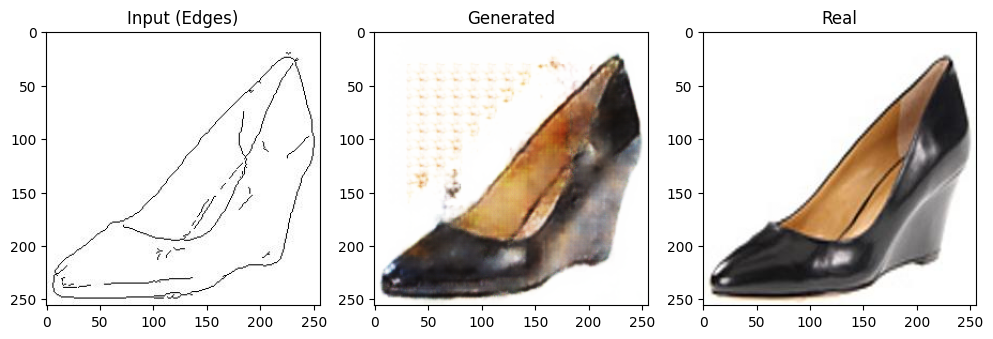

In [ ]:
import matplotlib.pyplot as plt

generator.eval()

input_img, target_img = next(iter(train_loader))
input_img = input_img.to(DEVICE)

with torch.no_grad():
    fake_img = generator(input_img)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Input (Edges)")
plt.imshow(input_img[0].permute(1,2,0).cpu()*0.5+0.5)

plt.subplot(1,3,2)
plt.title("Generated")
plt.imshow(fake_img[0].permute(1,2,0).cpu()*0.5+0.5)

plt.subplot(1,3,3)
plt.title("Real")
plt.imshow(target_img[0].permute(1,2,0)*0.5+0.5)

plt.show()

In [ ]:
import os
os.makedirs("generated_outputs", exist_ok=True)
print("Folder created:", os.path.exists("generated_outputs"))

Folder created: True


In [ ]:
import torch
import matplotlib.pyplot as plt
import os

generator.eval()

count = 0

for input_img, target_img in train_loader:
    input_img = input_img.to(DEVICE)

    with torch.no_grad():
        fake_img = generator(input_img)

    for i in range(fake_img.size(0)):
        fake = fake_img[i].permute(1,2,0).cpu()*0.5+0.5
        fake = fake.clamp(0,1)

        plt.imsave(f"generated_outputs/output_{count}.png", fake.numpy())
        count += 1

        if count >= 10:
            break
    if count >= 10:
        break

print("Saved files:", os.listdir("generated_outputs"))

Saved files: ['output_5.png', 'output_3.png', 'output_7.png', 'output_1.png', 'output_8.png', 'output_0.png', 'output_2.png', 'output_6.png', 'output_9.png', 'output_4.png']


In [ ]:
!zip -r outputs.zip generated_outputs

  adding: generated_outputs/ (stored 0%)
  adding: generated_outputs/output_5.png (deflated 0%)
  adding: generated_outputs/output_3.png (deflated 0%)
  adding: generated_outputs/output_7.png (deflated 0%)
  adding: generated_outputs/output_1.png (deflated 0%)
  adding: generated_outputs/output_8.png (deflated 0%)
  adding: generated_outputs/output_0.png (deflated 0%)
  adding: generated_outputs/output_2.png (deflated 0%)
  adding: generated_outputs/output_6.png (deflated 0%)
  adding: generated_outputs/output_9.png (deflated 0%)
  adding: generated_outputs/output_4.png (deflated 0%)


In [1]:
from google.colab import files
files.download("outputs.zip")

FileNotFoundError: Cannot find file: outputs.zip